# Testing object segmentation 
- I have used Napari to train segment_classifier_backg_roundcells.cl
- To see how the prediction works on other images I load each image and run the predictor on it
- As a result I plot the original image and segmented image with predicted number of objects in the image

In [1]:
from skimage.io import imread, imshow, imsave
import pyclesperanto_prototype as cle
import numpy as np
import apoc
from apoc import ObjectSegmenter
import os
import pandas as pd
import matplotlib.pyplot as plt

def extract_object_properties(result):
    from skimage.measure import regionprops
    props = regionprops(result)
    properties = {
        "label": [],
        "area": [],
        "centroid_x": [],
        "centroid_y": [],
    }
    for prop in props:
        properties["label"].append(prop.label)
        properties["area"].append(prop.area)
        properties["centroid_x"].append(prop.centroid[0])
        properties["centroid_y"].append(prop.centroid[1])
    return properties

def evaluate_predictions(files_evaluated, ignore_file=""):
    deviations=[]
    for file, info in files_evaluated.items():
        if file == ignore_file:
            continue
        count, _, _ = info
        true_avg = np.mean(gold_counts[file])
        deviation= abs(count - true_avg) / true_avg
        deviations.append(deviation)
    val = np.mean(deviations)
    return np.round(val * 100,2)

I prepare true counts for each image as given by manual annotation of the image (https://bbbc.broadinstitute.org/BBBC001). Two different human observers counted the number of cells in the image (their reports varies by 11%). 

In [2]:
ground_truth = """AS_09125_050118150001_A03f00d0.tif	350	362
AS_09125_050118150001_A03f01d0.tif	336	342
AS_09125_050118150001_A03f02d0.tif	396	447
AS_09125_050118150001_A03f03d0.tif	320	341
AS_09125_050118150001_A03f04d0.tif	398	533
AS_09125_050118150001_A03f05d0.tif	241	257"""
gold_counts={}
for line in ground_truth.split("\n"):
    file, c1,c2 = line.split()
    gold_counts[file]=[int(c1),int(c2)]

Prepare path to the folder that contains images for dataset Human HT29 colon-cancer cells (version BBBC001). 

In [3]:
dataset001=r'..\BBBC001_v1_images_tif\human_ht29_colon_cancer_1_images'

Loading ObjectSegmenter trained in Napari by using object segmentation (apoc). 

In [4]:
# My trained segmenter
segmenter = ObjectSegmenter(opencl_filename='segment_classifier_backg_roundcells.cl')


I iterate over all images in a given folder (6 images in total) and run the predictor on the images. From the result of the segmentation I extract the number of cells that were detected in the image.

In [5]:
def get_predictions(files_source, predictor):
    files_evaluated = {}
    for test_image in os.listdir(files_source):
        image = imread(fr'..\BBBC001_v1_images_tif\human_ht29_colon_cancer_1_images\{test_image}')
        result = predictor.predict(image=image)
        properties = extract_object_properties(result)
        df = pd.DataFrame(properties).set_index("label")
        files_evaluated[test_image] = [len(df), image, result]
    return files_evaluated

files_evaluated = get_predictions(dataset001,
                                  segmenter)

Plotting two images for one file. True picture with annotated counts (left) and segmented image with its predicted count of objects (right) in the image.

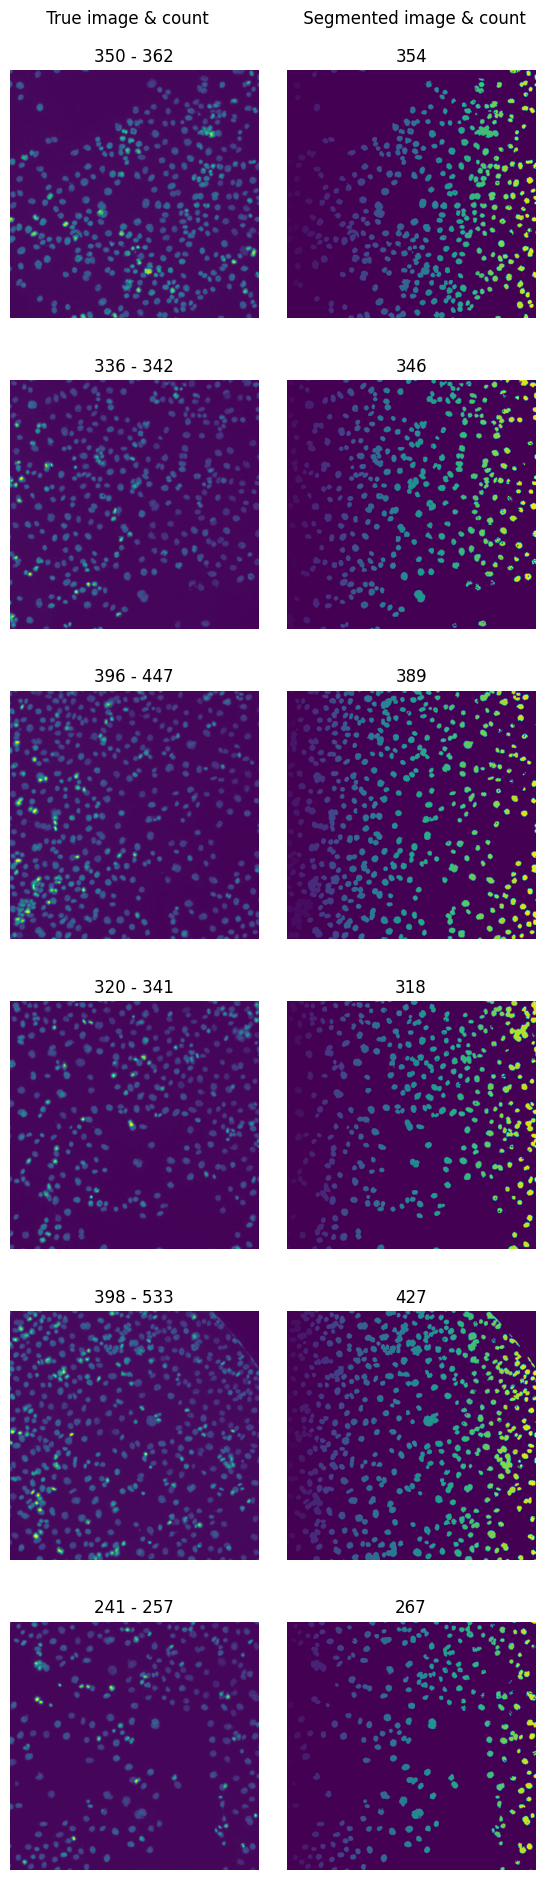

In [6]:
def plot_predictions(files_evaluated):
    fig, axes = plt.subplots(len(files_evaluated), 2, figsize=(15, 20))
    for i, (file, info) in enumerate(files_evaluated.items()):
        count, image, result = info
        # Add image and result to subplots
        axes[i, 0].imshow(image)
        axes[i,0].set_title(" - ".join(map(str, gold_counts[file])))
        axes[i, 0].axis("off")
        axes[i, 1].imshow(result)
        axes[i,1].set_title(count)
        axes[i, 1].axis("off")

    # Adjust the space between subplots
    fig.suptitle("     True image & count                  Segmented image & count")
    plt.subplots_adjust(left=0.1, right=0.9, top=0.95, bottom=0.05, wspace=-0.7, hspace=0.25)
    plt.show()

plot_predictions(files_evaluated)

Evaluating the performance using the suggested evaluation from the dataset website (how much does the predicted number of items differ from the mean of the annotated counts).
>To compare an algorithm's results to these, first compute for each image the absolute difference between the algorithm's count and the average of the humans' counts, then divide by the latter to obtain the deviation from ground truth (in percent). The mean of these values over all 6 images is the final result.


In [7]:
print(f"The resulting prediction of the classifier deviates by {evaluate_predictions(files_evaluated)}%")


The resulting prediction of the classifier deviates by 4.94%


To properly evaluate the performance of the predictor it is necessary to evaluate it only on image that was unseen during training. Therefore I exclude one image (that I used during training) and evaluate the classifier based on the other 5 images.

In [8]:
print(f"The resulting prediction of the classifier (excluding the image used for training) deviates by {evaluate_predictions(files_evaluated, ignore_file='AS_09125_050118150001_A03f00d0.tif')}%")

The resulting prediction of the classifier (excluding the image used for training) deviates by 5.81%


## Using napari-assistant

I decided to also look at napari-assistant which offers pretrained model for object segmenttion and see what will be the deviation in comparision to my trained model.

In [9]:
class NapariAssistant:
    def __init__(self) -> None:
        pass

    def predict(self, image):
        pred = cle.voronoi_otsu_labeling(image, None, 2.5, 1.0)
        return pred

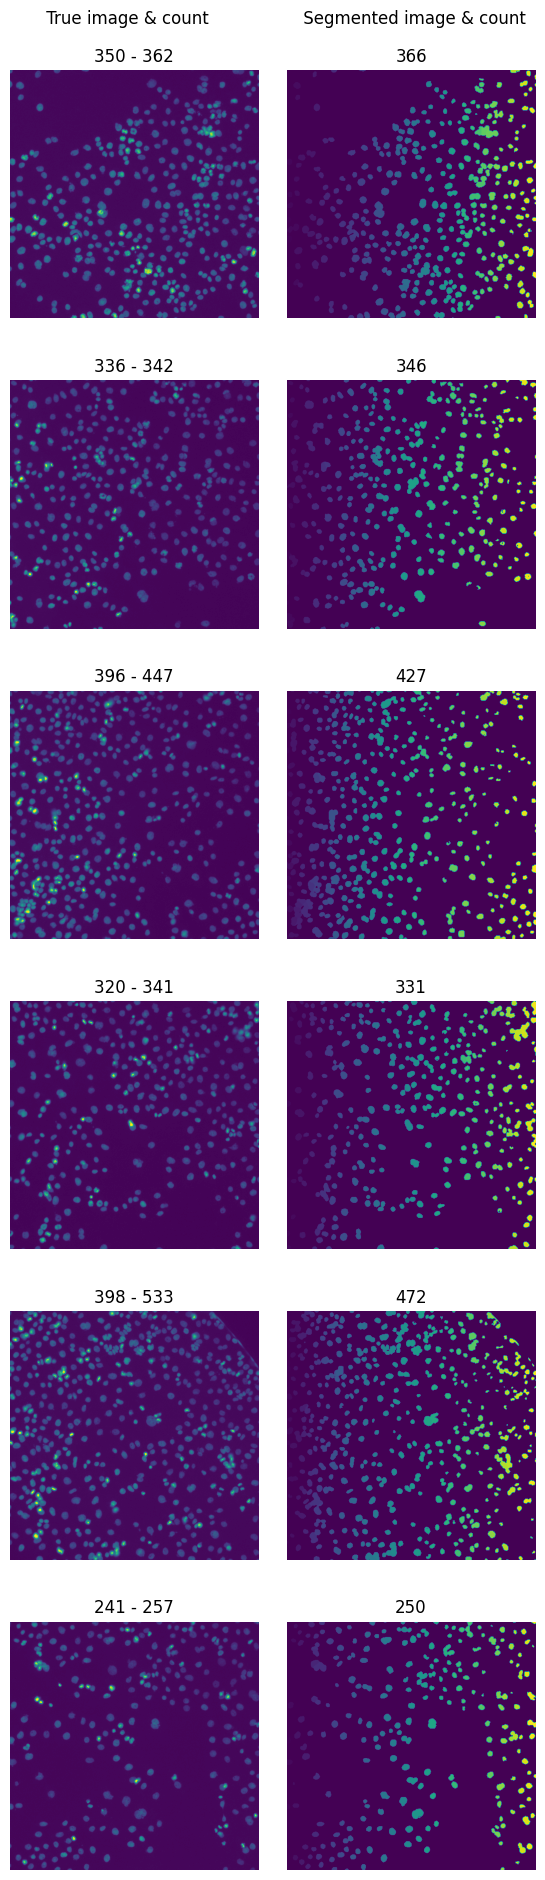

In [10]:
files_evaluated = get_predictions(files_source=dataset001, predictor=NapariAssistant())
plot_predictions(files_evaluated)


In [11]:
print(f"The resulting prediction of the classifier deviates by {evaluate_predictions(files_evaluated)}%")

The resulting prediction of the classifier deviates by 1.35%


The napari assistant has lower deviation error than my custom trained predictor.